## Supreme Court Voting Patterns

Plots of how the Supreme Court Justices have voted over the years, exploring which Justices most commonly vote together and how "split" any given court is.
Data is provided by http://scdb.wustl.edu/data.php

In [1]:
import os
import pathlib as path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from sklearn.cluster import KMeans

In [2]:
# Data is stored in same path as this script:
datapath = 'SCDB_2024_01_justiceCentered_Docket.csv'
df = pd.read_csv(datapath)

In [3]:
print('A random sample of Supreme Court case outcomes:')
df.loc[:,['caseName','dateDecision','chief','majVotes','minVotes']].sample(10,random_state=42).sort_index()

A random sample of Supreme Court case outcomes:


,caseName,dateDecision,chief,majVotes,minVotes
9555,"CHICAGO, ROCK ISLAND & PACIFIC RAILROAD CO. v....",1/18/54,Warren,7,2
25182,NATIONAL LABOR RELATIONS BOARD v. METROPOLITAN...,4/5/65,Warren,8,1
35642,In re BURRUS et al.,6/21/71,Burger,5,4
46368,VENDO CO. v. LEKTRO-VEND CORP. et al.,6/29/77,Burger,5,4
60419,UNITED STATES v. MAINE et al.,2/25/86,Burger,8,0
69454,"THOMAS C. RAPONE, COMMISSIONER OF CORRECTION O...",1/15/92,Rehnquist,6,2
74857,COMMISSIONER OF INTERNAL REVENUE v. ESTATE OF ...,3/18/97,Rehnquist,7,2
78681,"LACKAWANNA COUNTY DISTRICT ATTORNEY, et al. v....",4/25/01,Rehnquist,5,4
89864,COMPTROLLER OF THE TREASURY v. WYNNE,5/18/15,Roberts,5,4
95760,"COINBASE, INC. v. BIELSKI",6/23/23,Roberts,5,4


The "Vote" column indicates how a justice voted on a given case:

1. Voted with majority or plurality
2. Dissent
3. Regular concurrence
4. Special concurrence
5. Judgment of the Court
6. Dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
7. Jurisdictional dissent
8. Justice participated in an equally divided vote

Cases where a justice did not vote or participate are marked 'nan'.

For our purposes we will lump all concurrences together and all dissents together. I.E. anyone dissenting is considered voting with every other dissenting justice, and every concurrence is considered a vote with the majority. 

### First, let's look at the most recent term (2023 at time of writing):

I am primarily interested in how polarized the court is. First, let's take a simple look at how often cases are unanimuous or split. We can use the columns *minVotes* and *majVotes* (counting the number of votes in the minority and majority, respectively) to accomplish this. 

In the 2023 term there were 18 cases without 9 voting justices (due in part to the appointment of newest justice, Ketanji Brown Jackson). We will ignore these to simplify our plot for now and get back to them later.

In [4]:
# Trim down to just the 2023 term:
df_2023 = df.loc[df['term'] == 2023]

vote_counts = df_2023.loc[:,['majVotes','minVotes']]
vote_counts['total'] = vote_counts['majVotes'] + vote_counts['minVotes']
vote_counts = vote_counts.loc[vote_counts['total'] == 9,:].reset_index()
vote_counts = vote_counts.groupby(['majVotes','minVotes']).size().reset_index()
vote_counts = vote_counts.rename({0:'n_cases'},axis=1)
labels = vote_counts.apply(lambda x : str(x['majVotes']) + '-' + str(x['minVotes']), axis=1)
vote_counts['label'] = labels
vote_counts

,majVotes,minVotes,n_cases,label
0,5,4,90,5-4
1,6,3,216,6-3
2,7,2,27,7-2
3,8,1,27,8-1
4,9,0,243,9-0


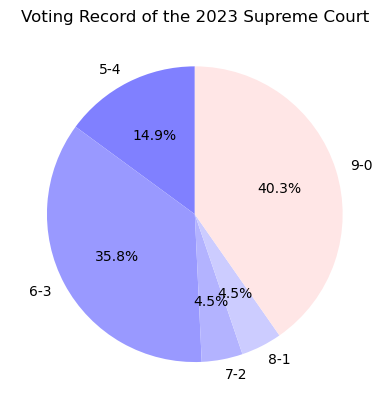

In [5]:
# Create a simple pie chart
colors = [[0.5,0.5,1],[0.6,0.6,1],[0.7,0.7,1],[0.8,0.8,1],[1,0.9,0.9]]
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pie(vote_counts['n_cases'], labels=vote_counts['label'],colors=colors,
      startangle=90,autopct='%1.1f%%')
plt.title('Voting Record of the 2023 Supreme Court')
plt.show()

By a small amount, the majority of decisions are divided. As I am primarily interested in seeing how closely aligned different justices are to eachother when they are voting, I will omit the unanimous decisions going forward.

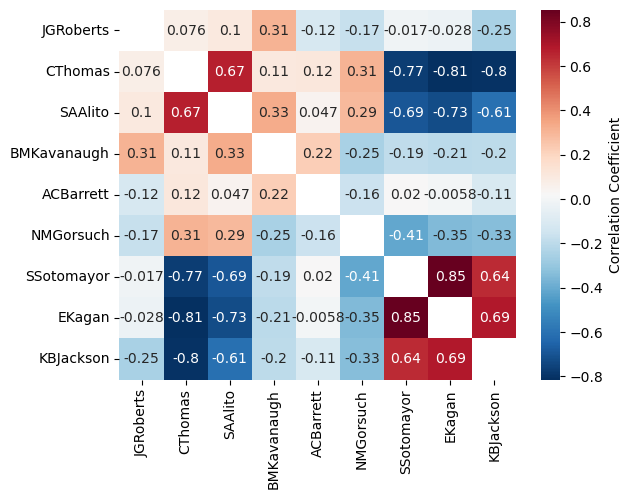

In [6]:
# Remove all cases that were unanimous, i.e. number of dissenting votes == 0
df_2023 = df_2023.loc[df_2023['minVotes']!=0]
# Each vote is uniquely indexed by a "Docket ID".
# This is different from a Case ID, as some cases have multiple parts and thus multiple votes. 
docketIds = df_2023['docketId'].unique()

# For ease of plotting later, I have put the justices in a static order, with Chief Justice Roberts first,
# followed by the conservative justices, then the liberal justices.
justiceOrder = ['JGRoberts', 'CThomas', 'SAAlito', 'BMKavanaugh', 'ACBarrett',
       'NMGorsuch', 'SSotomayor','EKagan','KBJackson']

# For each justice, get a vector of their votes, where 1=voting with the majority, -1=dissenting, and 0= no vote/abstain
voteMat = np.zeros([len(docketIds),len(justiceOrder)])

for i in range(len(justiceOrder)):
    j = justiceOrder[i]
    v = df_2023.loc[df_2023['justiceName']==j,'vote']
    v[v.isin([1,3,4,5])] = 1
    v[v.isin([2,7])] = -1
    v = v.fillna(0)
    v=v.to_numpy()
    
    voteMat[:,i] = v
# Run a correlation to see which justices are most aligned and which most often vote in opposition to eachother
corrMat = np.corrcoef(voteMat.T)
np.fill_diagonal(corrMat,'nan')
sns.heatmap(corrMat,annot=True,xticklabels=justiceOrder,yticklabels=justiceOrder,
           cmap='RdBu_r',cbar_kws={'label': 'Correlation Coefficient'})
plt.show()
from scipy.io import savemat
savemat('voting matrix.mat',{'Justices':justiceOrder,'Votes':voteMat})

The above matrix displays how well correlated the justices' voting histories are with eachother. A value of 1 indicates that two justices always vote in agreement with eachother (on split decisions), while a value of -1 indicates that they always vote in opposition. We can already see that the liberal justices Sotomayor, Kagan, and Jackson's voting records are very highly correlated with eachother, compared to the other justices.

---

Another method we could use is looking at the percent of cases two justices voted together on a case:

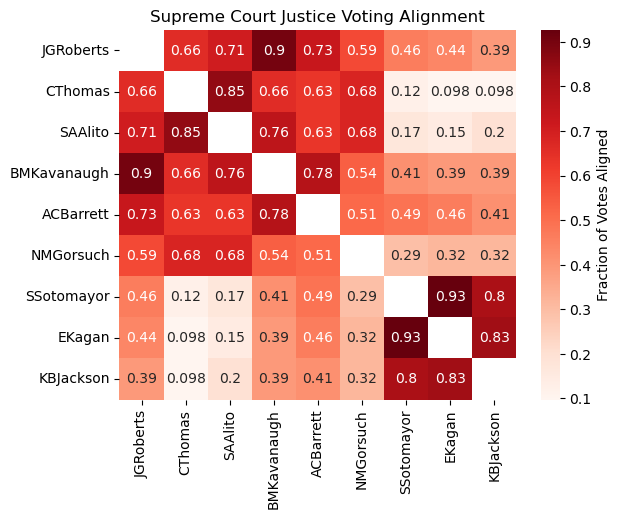

In [7]:
# For each case, create a matrix depicting which justices voted together
voteMat_count = np.zeros([9,9])

# For each case, count if each justice voted in the majority or minority
# and which other justices they agreed with. 
for case in docketIds:
    currdata = df_2023[df_2023['docketId']==case]
    currdata.set_index('justiceName',inplace=True)
    votes = currdata.loc[justiceOrder,'vote']
    maj_votes = votes.isin([1,3,4,5]).to_numpy()
    dis_votes = votes.isin([2,7]).to_numpy()
    matrix = np.outer(maj_votes,maj_votes) + np.outer(dis_votes,dis_votes)
    voteMat_count += matrix


np.fill_diagonal(voteMat_count,'nan')
# Convert from counts to fraction of cases
n_cases = len(docketIds);
voteMat_frac = voteMat_count / n_cases

sns.heatmap(voteMat_frac,cmap='Reds',yticklabels=justiceOrder,xticklabels=justiceOrder,
           cbar_kws={'label': 'Fraction of Votes Aligned'},annot=True)
plt.title('Supreme Court Justice Voting Alignment')
plt.show()

### The 3-3-3 Court
One supposed theory about the Robert's court is that it is not simply divided along liberal/conservative lines, but that it is split into three groups of three justices each along liberal/moderate/conservative lines, with Roberts, Barrett, and Kavanaugh comprising the moderate camp. \
We can investigate this hypothesis by performing clustering analysis of the justices based on their voting history.

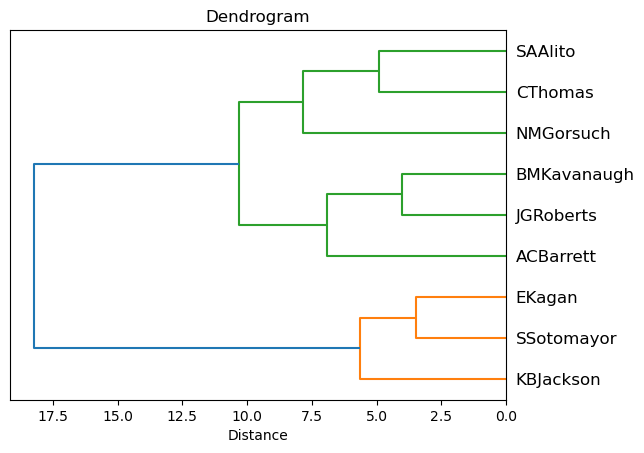

In [8]:
# Hierarchical clustering using the vote vectors (same as in our correlation matrix)
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(voteMat.T, method='ward',optimal_ordering=False)

plt.figure()
dendrogram(linkage_matrix,labels=justiceOrder,orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()


In [9]:
print(justiceOrder)
linkage_matrix

['JGRoberts', 'CThomas', 'SAAlito', 'BMKavanaugh', 'ACBarrett', 'NMGorsuch', 'SSotomayor', 'EKagan', 'KBJackson']


array([[ 6.        ,  7.        ,  3.46410162,  2.        ],
       [ 0.        ,  3.        ,  4.        ,  2.        ],
       [ 1.        ,  2.        ,  4.89897949,  2.        ],
       [ 8.        ,  9.        ,  5.65685425,  3.        ],
       [ 4.        , 10.        ,  6.92820323,  3.        ],
       [ 5.        , 11.        ,  7.83156008,  3.        ],
       [13.        , 14.        , 10.32795559,  6.        ],
       [12.        , 15.        , 18.24524291,  9.        ]])

From this we can see that the "conservatives" Alito, Thomas, and Gorsuch are more closely aligned in their voting trends than the "moderates" Roberts, Kavanaugh, and Barret. However, the moderates are *much* closer to the conservatives than they are to the liberals. Indeed our default clustering algorithm only identifies two primary clusters, (It should be noted, though, that there are other methods of clustering that could produce a greater number of 'significant' groups).


---

Another method of visualization and quantification of Supreme Court justices' voting patterns is through a *network graph*. Here we create a graph where each *node* represents a justice, with *edges* drawn between justices indicating their voting alignment. A thicker edge indicates that the two jstices vote in concert often. 

For this particular graph, I am using the correlation coefficients from our first heatmap plot, ommitting any coefficients less than 0.

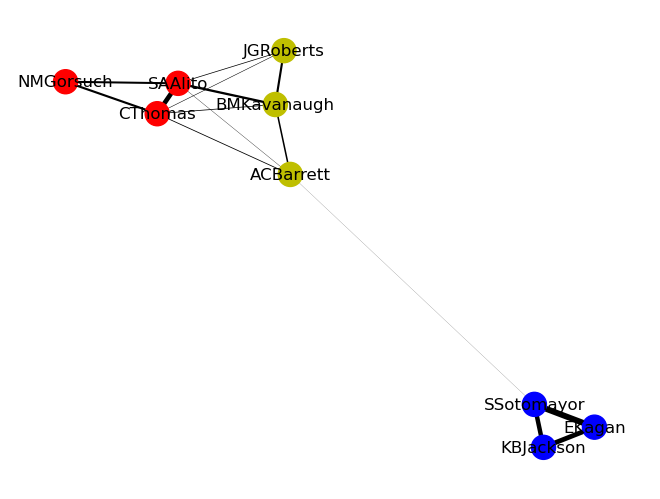

In [10]:
# Create a Graph object and use our matrix to populate it:
G = nx.Graph()
num_nodes = corrMat.shape[0]
for i in range(num_nodes):
    for j in range(i, num_nodes):  # Only iterate over upper triangle
        weight = corrMat[i,j]
        #weight = voteMat_frac[i,j]
        if weight > 0:
            G.add_edge(i, j, weight=weight)

# Add labels to the nodes:
node_labels = {i:j for i,j in zip(range(9),justiceOrder)}
node_colors = ['y','r','r','y','y','r','b','b','b']
# Define line widths from edge weights:
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
lineWidths = np.array(weights)*5
G = nx.relabel_nodes(G, node_labels)
pos = nx.spring_layout(G,weight='weight',iterations=100,seed=42)
nx.draw(G, pos,with_labels=True,node_color=node_colors,width=lineWidths)
plt.show()



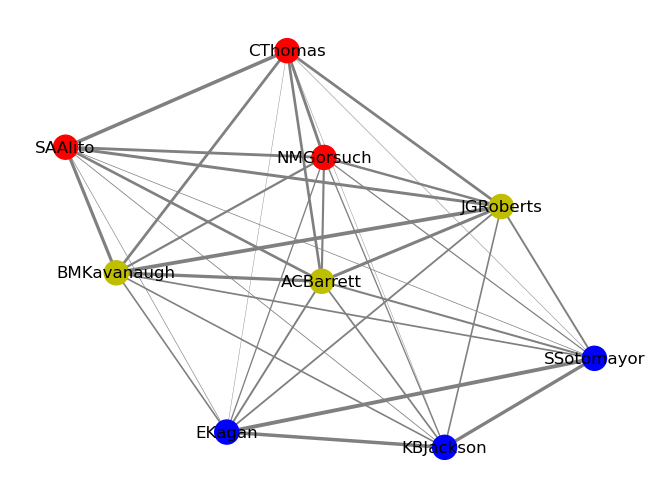

In [11]:
# Create a Graph object and use our matrix to populate it:
G = nx.Graph()
num_nodes = voteMat_frac.shape[0]
for i in range(num_nodes):
    for j in range(i, num_nodes):  # Only iterate over upper triangle
        #weight = corrMat[i,j]
        weight = voteMat_frac[i,j]
        if weight > 0:
            G.add_edge(i, j, weight=weight)

# Add labels to the nodes:
node_labels = {i:j for i,j in zip(range(9),justiceOrder)}
node_colors = ['y','r','r','y','y','r','b','b','b']
# Define line widths from edge weights:
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
lineWidths = np.array(weights)*3
G = nx.relabel_nodes(G, node_labels)
pos = nx.spring_layout(G,weight='weight',iterations=100,seed=42)
nx.draw(G, pos,with_labels=True,node_color=node_colors,width=lineWidths,edge_color=[0.5,0.5,0.5])
plt.show()



In [12]:
def edge_weight_complement(u,v,E):
    try:
        return 1-E['weight']
    except:
        return None
edge_weight_complement(G.nodes['JGRoberts'],G.nodes['CThomas'],G.edges['JGRoberts','CThomas'])

0.3414634146341463

JGRoberts : 0
BMKavanaugh : 0.098
ACBarrett : 0.268
SAAlito : 0.293
CThomas : 0.341
NMGorsuch : 0.415
SSotomayor : 0.537
EKagan : 0.561
KBJackson : 0.61


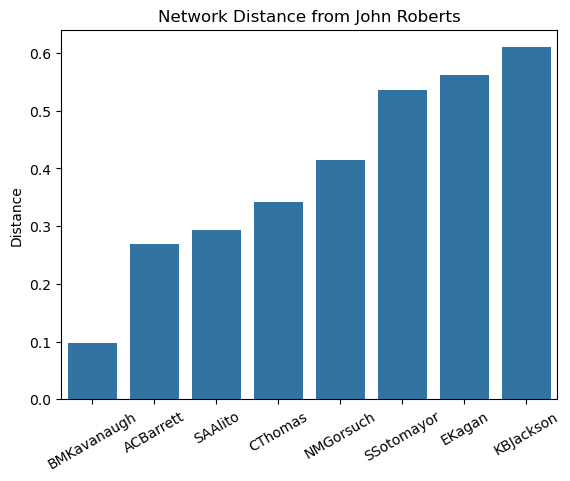

In [13]:
# Measure path length between Roberts and each other justice:
roberts_pathlengths = nx.shortest_path_length(G,source='JGRoberts',weight=edge_weight_complement)
for x in roberts_pathlengths:
    print(x,':',np.round(roberts_pathlengths[x],3))
    
sns.barplot(x=list(roberts_pathlengths.keys())[1::],y=list(roberts_pathlengths.values())[1::])
plt.xticks(rotation=30)
plt.ylabel('Distance')
plt.title('Network Distance from John Roberts')
plt.show()

### The Past 20 Years 
Let's look at the recent history of the court and make the same network plots. 

The number and appointments of the justices are not always consistent throughout a term. First we should identify the most stable group of 9 justices within each year. Then we will trim out the cases that aren't composed of exactly those justices.

In [14]:
# Create a dictionary of justice IDs to justice names:
justiceIDs = df.loc[:,('justice','justiceName')].drop_duplicates().reset_index(drop=True)
justiceMap = {jID:name for jID,name in zip(justiceIDs['justice'],justiceIDs['justiceName'])}
# justiceMap

In [15]:
df_by_term = df.set_index(['term','docketId'])
years = list(range(1980,2023))
idx = pd.IndexSlice
df_by_term=df_by_term.loc[idx[years,:],:]
df_by_term

caseId    caseIssuesId                voteId dateDecision  \
term docketId                                                                   
1980 1980-001-01  1980-001  1980-001-01-01  1980-001-01-01-01-01     10/20/80   
     1980-001-01  1980-001  1980-001-01-01  1980-001-01-01-01-02     10/20/80   
     1980-001-01  1980-001  1980-001-01-01  1980-001-01-01-01-03     10/20/80   
     1980-001-01  1980-001  1980-001-01-01  1980-001-01-01-01-04     10/20/80   
     1980-001-01  1980-001  1980-001-01-01  1980-001-01-01-01-05     10/20/80   
...                    ...             ...                   ...          ...   
2022 2022-062-01  2022-062  2022-062-01-01  2022-062-01-01-01-05      6/23/23   
     2022-062-01  2022-062  2022-062-01-01  2022-062-01-01-01-06      6/23/23   
     2022-062-01  2022-062  2022-062-01-01  2022-062-01-01-01-07      6/23/23   
     2022-062-01  2022-062  2022-062-01-01  2022-062-01-01-01-08      6/23/23   
     2022-062-01  2022-062  2022-062-01-01  2022-062-01-01-01-09      6/23/23   

                  decisionType        usCite          sctCite  \
term docketId                                                   
1980 1980-001-01             2    449 U.S. 1    101 S. Ct. 42   
     1980-001-01             2    449 U.S. 1    101 S. Ct. 42   
     1980-001-01             2    449 U.S. 1    101 S. Ct. 42   
     1980-001-01             2    449 U.S. 1    101 S. Ct. 42   
     1980-001-01             2    449 U.S. 1    101 S. Ct. 42   
...                        ...           ...              ...   
2022 2022-062-01             1  599 U.S. 670  143 S. Ct. 1964   
     2022-062-01             1  599 U.S. 670  143 S. Ct. 1964   
     2022-062-01             1  599 U.S. 670  143 S. Ct. 1964   
     2022-062-01             1  599 U.S. 670  143 S. Ct. 1964   
     2022-062-01             1  599 U.S. 670  143 S. Ct. 1964   

                            ledCite             lexisCite  naturalCourt  ...  \
term docketId                                                            ...   
1980 1980-001-01     66 L. Ed. 2d 1   1980 U.S. LEXIS 151          1506  ...   
     1980-001-01     66 L. Ed. 2d 1   1980 U.S. LEXIS 151          1506  ...   
     1980-001-01     66 L. Ed. 2d 1   1980 U.S. LEXIS 151          1506  ...   
     1980-001-01     66 L. Ed. 2d 1   1980 U.S. LEXIS 151          1506  ...   
     1980-001-01     66 L. Ed. 2d 1   1980 U.S. LEXIS 151          1506  ...   
...                             ...                   ...           ...  ...   
2022 2022-062-01  216 L. Ed. 2d 624  2023 U.S. LEXIS 2639          1710  ...   
     2022-062-01  216 L. Ed. 2d 624  2023 U.S. LEXIS 2639          1710  ...   
     2022-062-01  216 L. Ed. 2d 624  2023 U.S. LEXIS 2639          1710  ...   
     2022-062-01  216 L. Ed. 2d 624  2023 U.S. LEXIS 2639          1710  ...   
     2022-062-01  216 L. Ed. 2d 624  2023 U.S. LEXIS 2639          1710  ...   

                 majVotes minVotes justice  justiceName vote  opinion  \
term docketId                                                           
1980 1980-001-01        9        0      94     PStewart  1.0      1.0   
     1980-001-01        9        0      98    TMarshall  1.0      1.0   
     1980-001-01        9        0      92    WJBrennan  1.0      1.0   
     1980-001-01        9        0      95      BRWhite  1.0      1.0   
     1980-001-01        9        0      99     WEBurger  1.0      1.0   
...                   ...      ...     ...          ...  ...      ...   
2022 2022-062-01        8        1     114       EKagan  1.0      1.0   
     2022-062-01        8        1     115    NMGorsuch  4.0      2.0   
     2022-062-01        8        1     116  BMKavanaugh  1.0      2.0   
     2022-062-01        8        1     117    ACBarrett  4.0      2.0   
     2022-062-01        8        1     118    KBJackson  1.0      1.0   

                  direction  majority  firstAgreement  secondAgreement  
term docketId                                           

In [17]:
df_20yrs = df.loc[(df['term'] <= 2024) & (df['term'] >= 1980)].reset_index()
justices_by_term = []
for year,df_year in df_20yrs.groupby('term'):
    list_of_term_justices = []
    for case_id,df_id in df_year.groupby('docketId'):
        # Convert to set data type so that ordering doesn't matter
        case_justices = set(df_id['justice'])
        list_of_term_justices.append(case_justices)
    justice_series = pd.Series(list_of_term_justices)
    # Get the set of justices that voted together the most (sorted list)
    justice_counts = justice_series.value_counts().reset_index().loc[0,'index']
    justices_by_term.append(justice_counts)
justices_by_term = pd.DataFrame({'term':np.arange(1980,2024),'justices':justices_by_term})
justices_by_term = justices_by_term.set_index('term',drop=True)

In [18]:
# Index over terms and remove cases that aren't decided by our specified groups of justices
df_20yrs['keep_for_analysis'] = True
df_20yrs = df_20yrs.reset_index().set_index(['term','docketId'])
for term,term_df in df_20yrs.groupby('term'):
    for docketId,docket_df in term_df.groupby('docketId'):
        case_justices = set(docket_df['justice'].to_list())
        # print(case_justices)
        # print(justices_by_term.loc[term,'justices'])
        if case_justices != justices_by_term.loc[term,'justices']:
            df_20yrs.loc[(term,docketId),'keep_for_analysis'] = False
# Drop unwanted cases
df_20yrs = df_20yrs.reset_index()
df_20yrs = df_20yrs.loc[df_20yrs['keep_for_analysis']]
df_20yrs = df_20yrs.set_index(['term','docketId'])
# Replace votes with simplified votes of majority, dissent, abstain/absent
vote_map = {1:1,
            2:-1,
            3:1,
            4:1,
            5:1,
            6:-1,
            7:-1}
df_20yrs['vote_simple'] = df_20yrs['vote'].map(vote_map,na_action=None)
df_20yrs['vote_simple'] = df_20yrs['vote_simple'] .fillna(0)

### Generating voting data from each court

We will now apply the same analyses we used on the 2023 term to each of the other terms over the past 20 years. \
First we will create a dataframe that has a single row per case, rather than per vote. \
Then we will rewrite our previous analyses as functions and apply them each to the rows of the new dataframe.

In [19]:
df_by_case = df_20yrs.reset_index().loc[:,['term','docketId']].drop_duplicates().reset_index(drop=True)
df_by_case = df_by_case.set_index(['term','docketId'])
df_by_case.loc[:,'justice'] = np.zeros(df_by_case.shape[0],dtype='object')
df_by_case.loc[:,'vote'] = np.zeros(df_by_case.shape[0],dtype='object')
df_by_case.loc[:,['majVotes','minVotes']] = 0
# df_by_case.loc[:,'vote'] = np.zeros(df_by_case.shape[0],dtype='object')

In [20]:
case_justices = []
case_votes = []
for (term,docketId) in df_by_case.index:
    case_justices.append(df_20yrs.loc[(term,docketId),'justice'].values)
    case_votes.append(df_20yrs.loc[(term,docketId),'vote_simple'].values)
    df_by_case.loc[(term,docketId),'chief'] = df_20yrs.loc[(term,docketId),'chief'].values[0]
    df_by_case.loc[(term,docketId),'majVotes'] = df_20yrs.loc[(term,docketId),'majVotes'].values[0]
    df_by_case.loc[(term,docketId),'minVotes'] = df_20yrs.loc[(term,docketId),'minVotes'].values[0]
df_by_case['justice'] = case_justices
df_by_case['vote'] = case_votes
df_by_case['justiceName'] = df_by_case.apply(lambda x : [justiceMap[jID] for jID in x['justice']],axis=1)

# df_by_case.loc[:,('majVotes','minVotes')] = df_by_case.loc[:,('majVotes','minVotes')].astype(int)

# Reorder columns
df_by_case = df_by_case.loc[:,('chief','justiceName','vote','majVotes','minVotes')]
df_by_case

chief                                        justiceName  \
term docketId                                                                  
1980 1980-001-01   Burger  [PStewart, TMarshall, WJBrennan, BRWhite, WEBu...   
     1980-002-01   Burger  [WEBurger, WJBrennan, PStewart, BRWhite, TMars...   
     1980-003-01   Burger  [PStewart, TMarshall, WJBrennan, BRWhite, WEBu...   
     1980-004-01   Burger  [WEBurger, WJBrennan, PStewart, BRWhite, TMars...   
     1980-005-01   Burger  [WEBurger, WJBrennan, PStewart, BRWhite, TMars...   
...                   ...                                                ...   
2023 2023-060-01  Roberts  [JGRoberts, CThomas, SAAlito, SSotomayor, EKag...   
     2023-060-02  Roberts  [JGRoberts, CThomas, SAAlito, SSotomayor, EKag...   
     2023-061-01  Roberts  [JGRoberts, CThomas, SAAlito, SSotomayor, EKag...   
     2023-062-01  Roberts  [JGRoberts, CThomas, SAAlito, SSotomayor, EKag...   
     2023-062-02  Roberts  [JGRoberts, CThomas, SAAlito, SSotomayor, EKag...   

                                                               vote  majVotes  \
term docketId                                                                   
1980 1980-001-01      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   
     1980-002-01    [-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0]         7   
     1980-003-01      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   
     1980-004-01    [1.0, 1.0, 0.0, -1.0, 1.0, -1.0, 1.0, 1.0, 0.0]         5   
     1980-005-01  [-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0]         5   
...                                                             ...       ...   
2023 2023-060-01   [1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0]         6   
     2023-060-02   [1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0]         6   
     2023-061-01   [1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0]         6   
     2023-062-01      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   
     2023-062-02      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   

                  minVotes  
term docketId               
1980 1980-001-01         0  
     1980-002-01         2  
     1980-003-01         0  
     1980-004-01         2  
     1980-005-01         4  
...                    ...  
2023 2023-060-01         3  
     2023-060-02         3  
     2023-061-01         3  
     2023-062-01         0  
     2023-062-02         0  

[4925 rows x 5 columns]

In [21]:
# Summarize voting outcomes (as 9-0, 5-4, etc)
df_by_case['outcome'] = df_by_case.apply(lambda x: str(x['majVotes'])+'-'+str(x['minVotes']),axis=1)

# Put justices in the same order for each case within a term, and sort the votes accordingly
# (Occasionally they are in a different order)
for (term,case),df in df_by_case.groupby(['term','docketId']):
    sort_inds = np.argsort(df['justiceName'].values[0])
    justice_sorted = [df['justiceName'].values[0][ind] for ind in sort_inds]
    vote_sorted = [df['vote'].values[0][ind] for ind in sort_inds]
    # print(df['justiceName'])
    df['vote'] = [vote_sorted]
    # print(df['justiceName'])
    df['justiceName'] = [justice_sorted]
    df_by_case.loc[(term,case),:] = df.squeeze()

df_by_case

chief                                        justiceName  \
term docketId                                                                  
1980 1980-001-01   Burger  [BRWhite, HABlackmun, JPStevens, LFPowell, PSt...   
     1980-002-01   Burger  [BRWhite, HABlackmun, JPStevens, LFPowell, PSt...   
     1980-003-01   Burger  [BRWhite, HABlackmun, JPStevens, LFPowell, PSt...   
     1980-004-01   Burger  [BRWhite, HABlackmun, JPStevens, LFPowell, PSt...   
     1980-005-01   Burger  [BRWhite, HABlackmun, JPStevens, LFPowell, PSt...   
...                   ...                                                ...   
2023 2023-060-01  Roberts  [ACBarrett, BMKavanaugh, CThomas, EKagan, JGRo...   
     2023-060-02  Roberts  [ACBarrett, BMKavanaugh, CThomas, EKagan, JGRo...   
     2023-061-01  Roberts  [ACBarrett, BMKavanaugh, CThomas, EKagan, JGRo...   
     2023-062-01  Roberts  [ACBarrett, BMKavanaugh, CThomas, EKagan, JGRo...   
     2023-062-02  Roberts  [ACBarrett, BMKavanaugh, CThomas, EKagan, JGRo...   

                                                               vote  majVotes  \
term docketId                                                                   
1980 1980-001-01      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   
     1980-002-01    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]         7   
     1980-003-01      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   
     1980-004-01    [-1.0, -1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]         5   
     1980-005-01  [1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0]         5   
...                                                             ...       ...   
2023 2023-060-01   [1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]         6   
     2023-060-02   [1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]         6   
     2023-061-01   [1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0]         6   
     2023-062-01      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   
     2023-062-02      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]         9   

                  minVotes outcome  
term docketId                       
1980 1980-001-01         0     9-0  
     1980-002-01         2     7-2  
     1980-003-01         0     9-0  
     1980-004-01         2     5-2  
     1980-005-01         4     5-4  
...                    ...     ...  
2023 2023-060-01         3     6-3  
     2023-060-02         3     6-3  
     2023-061-01         3     6-3  
     2023-062-01         0     9-0  
     2023-062-02         0     9-0  

[4925 rows x 6 columns]

In [22]:
v = ['a','x','b','v']
s = np.argsort(v)
[v[i] for i in s]

['a', 'b', 'v', 'x']

#### Vote Matrices by Term
Now that we have aggregated our data on a term-by-term and case-by-case basis, we can more easily compare how each justice voted in each year.\
As before, we will only consider non-unanimous votes

In [23]:
# Drop unanimous votes:
df_by_case_contr = df_by_case.loc[df_by_case['minVotes']>0]
df_by_case_contr = df_by_case_contr.reset_index()
# index = df_by_case_contr.index
# voteMat_placeholder = pd.Series(np.zeros(df_by_case_contr.shape[0]).astype('object'),index=index)
df_by_case_contr['voteMat'] = np.zeros(df_by_case_contr.shape[0]).astype('object')
df_by_case_contr = df_by_case_contr.set_index(['term','docketId'])
# df_by_case_contr['voteMat'] = np.zeros(df_by_case_contr.shape[0],dtype='object')
# For each case, create a matrix of which justices voted together
voteMat_list = []
for (term,case),df in df_by_case_contr.groupby(['term','docketId']):
    # Drop unanimous votes
    votes_pro = (np.array(df['vote'].values[0]) == 1).astype(int)
    votes_anti = (np.array(df['vote'].values[0]) == -1).astype(int)
    voteMat = np.outer(votes_pro,votes_pro) + np.outer(votes_anti,votes_anti)
    voteMat_list.append(voteMat)
    df.loc[:,'voteMat'] = [voteMat]
    df_by_case_contr.loc[(term,case),:] = df.squeeze()
df_by_case_contr.sample(5)

,,chief,justiceName,vote,majVotes,minVotes,outcome,voteMat
term,docketId,,,,,,,
1988,1988-023-02,Rehnquist,"[AMKennedy, AScalia, BRWhite, HABlackmun, JPSt...","[1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",8,1,8-1,"[[1, 0, 1, 1, 1, 1, 1, 1, 1], [0, 1, 0, 0, 0, ..."
1993,1993-015-01,Rehnquist,"[AMKennedy, AScalia, CThomas, DHSouter, HABlac...","[1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0]",7,2,7-2,"[[1, 1, 1, 1, 0, 0, 1, 1, 1], [1, 1, 1, 1, 0, ..."
1983,1983-019-01,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, SDO...","[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0]",5,4,5-4,"[[1, 0, 1, 0, 0, 1, 0, 0, 1], [0, 1, 0, 1, 1, ..."
1989,1989-103-02,Rehnquist,"[AMKennedy, AScalia, BRWhite, HABlackmun, JPSt...","[1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0]",5,4,5-4,"[[1, 1, 0, 1, 0, 0, 1, 0, 1], [1, 1, 0, 1, 0, ..."
1983,1983-067-02,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, SDO...","[1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0]",6,3,6-3,"[[1, 1, 0, 1, 1, 0, 1, 1, 0], [1, 1, 0, 1, 1, ..."


In [24]:
# Sum over each term and divide by total cases in a term to get proportion of votes
# Aggregate all vote vectors into a single matrix for hierarchical clustering
voteMat_by_term = []
allVotes_by_term = []
for term,df in df_by_case_contr.groupby('term'):
    voteMat_all = df['voteMat']
    voteMat_sum = np.sum(voteMat_all);
    voteMat_frac = voteMat_sum / df.shape[0]
    np.fill_diagonal(voteMat_frac,'nan')
    justices = np.vstack(df['justiceName'].values)
    voteMat_by_term.append(voteMat_frac)
    allVotes_by_term.append(np.vstack(df['vote'].values))
# Organize into a dataframe with justice information
terms = df_by_case_contr.index.get_level_values(0).unique().values
voteMat_df = pd.DataFrame({'term':terms,
                           'voteMat_frac':voteMat_by_term,
                           'allVotes':allVotes_by_term,
                          }).set_index('term')
voteMat_df = voteMat_df.join(df_by_case_contr.reset_index().set_index('term'),on='term',how='left')
voteMat_df = voteMat_df.groupby('term').first().loc[:,('chief','justiceName','voteMat_frac','allVotes')]

In [25]:
voteMat_df

,chief,justiceName,voteMat_frac,allVotes
term,,,,
1980,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, PSt...","[[nan, 0.5862068965517241, 0.5603448275862069,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1...."
1981,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, SDO...","[[nan, 0.6015037593984962, 0.518796992481203, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0..."
1982,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, SDO...","[[nan, 0.6416666666666667, 0.39166666666666666...","[[1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1..."
1983,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, SDO...","[[nan, 0.6283185840707964, 0.4336283185840708,...","[[1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -..."
1984,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, SDO...","[[nan, 0.6306306306306306, 0.44144144144144143...","[[1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1..."
1985,Burger,"[BRWhite, HABlackmun, JPStevens, LFPowell, SDO...","[[nan, 0.448, 0.488, 0.664, 0.736, 0.312, 0.78...","[[1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1..."
1986,Rehnquist,"[AScalia, BRWhite, HABlackmun, JPStevens, LFPo...","[[nan, 0.6910569105691057, 0.42276422764227645...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0..."
1987,Rehnquist,"[AMKennedy, AScalia, BRWhite, HABlackmun, JPSt...","[[nan, 0.3977272727272727, 0.3977272727272727,...","[[0.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1..."
1988,Rehnquist,"[AMKennedy, AScalia, BRWhite, HABlackmun, JPSt...","[[nan, 0.875, 0.7678571428571429, 0.4196428571...","[[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1..."


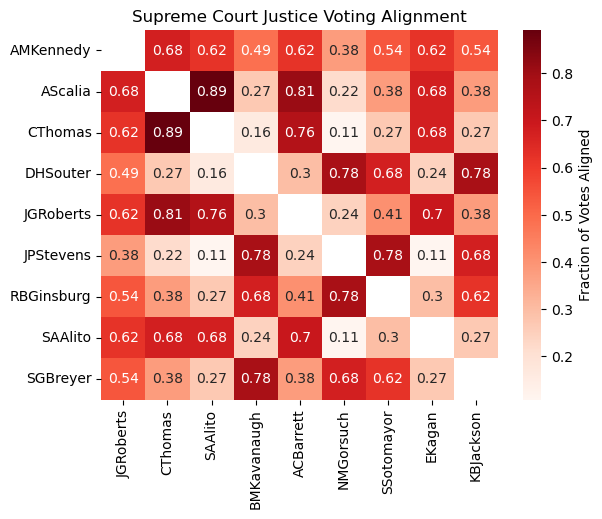

In [26]:
sns.heatmap(voteMat_df.loc[2005,'voteMat_frac'],cmap='Reds',
            yticklabels=voteMat_df.loc[2005,'justiceName'],xticklabels=justiceOrder,
           cbar_kws={'label': 'Fraction of Votes Aligned'},annot=True)
plt.title('Supreme Court Justice Voting Alignment')
plt.show()

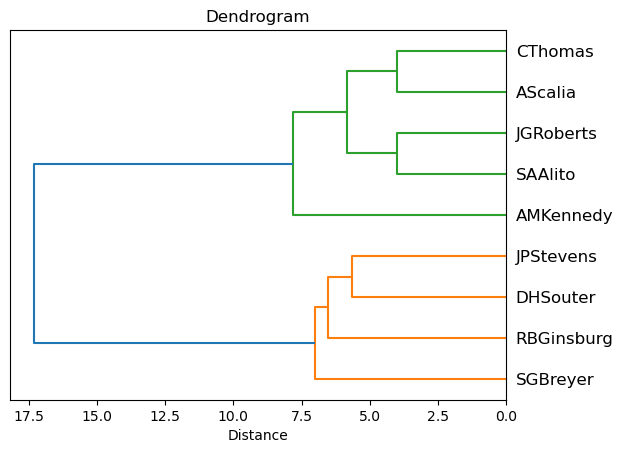

In [27]:
linkage_matrix = linkage(voteMat_df.loc[2005,'allVotes'].T, method='ward',optimal_ordering=True)
plt.figure()
dendrogram(linkage_matrix,labels=voteMat_df.loc[2005,'justiceName'],
            orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()

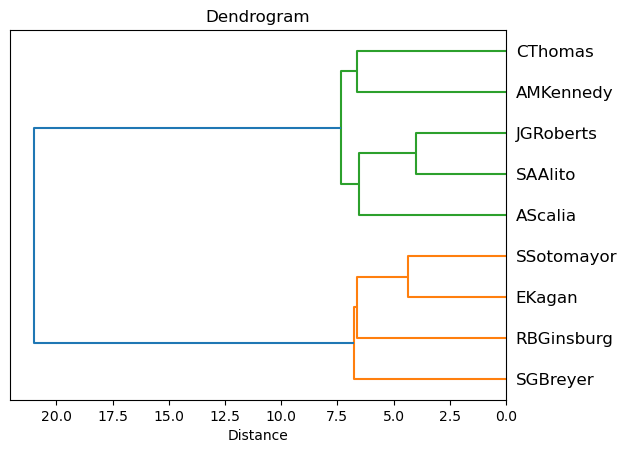

In [28]:
linkage_matrix = linkage(voteMat_df.loc[2010,'allVotes'].T, method='ward',optimal_ordering=True)
plt.figure()
dendrogram(linkage_matrix,labels=voteMat_df.loc[2010,'justiceName'],
            orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()

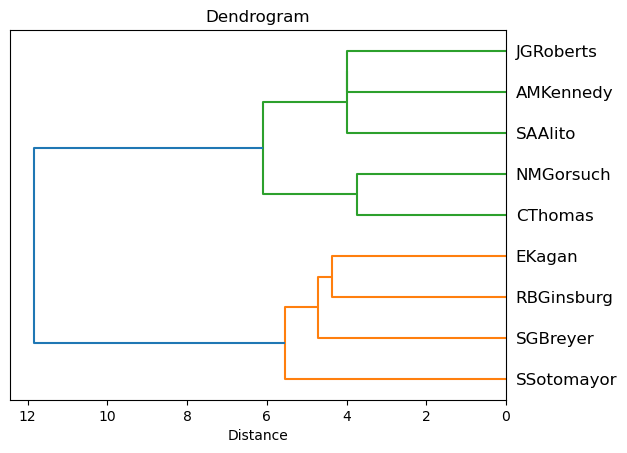

In [29]:
linkage_matrix = linkage(voteMat_df.loc[2016,'allVotes'].T, method='ward',optimal_ordering=True)
plt.figure()
dendrogram(linkage_matrix,labels=voteMat_df.loc[2016,'justiceName'],
            orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()


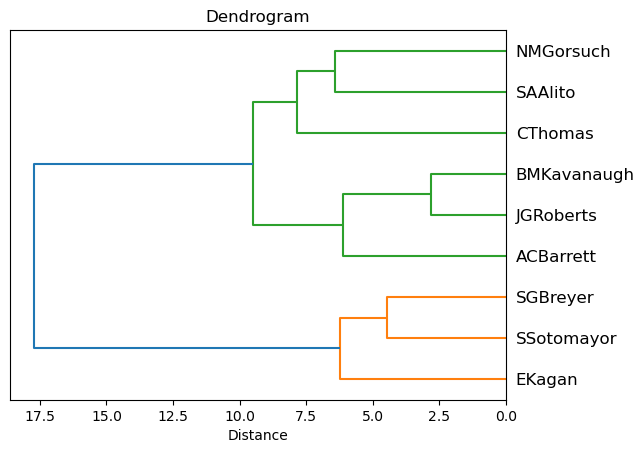

In [30]:
linkage_matrix = linkage(voteMat_df.loc[2020,'allVotes'].T, method='ward',optimal_ordering=True)
plt.figure()
dendrogram(linkage_matrix,labels=voteMat_df.loc[2020,'justiceName'],
            orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()


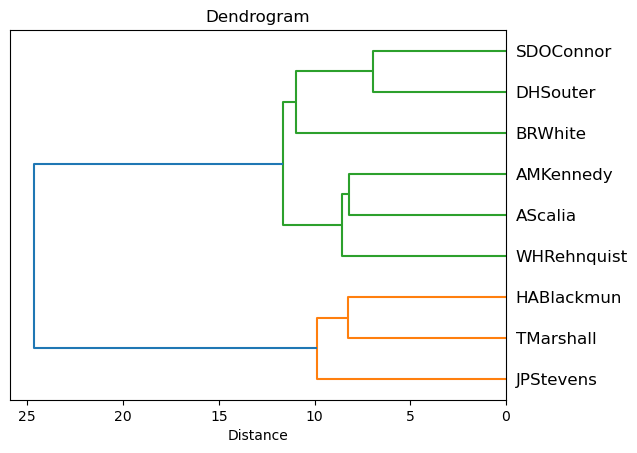

In [31]:
linkage_matrix = linkage(voteMat_df.loc[1990,'allVotes'].T, method='ward',optimal_ordering=True)
plt.figure()
dendrogram(linkage_matrix,labels=voteMat_df.loc[1990,'justiceName'],
            orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()

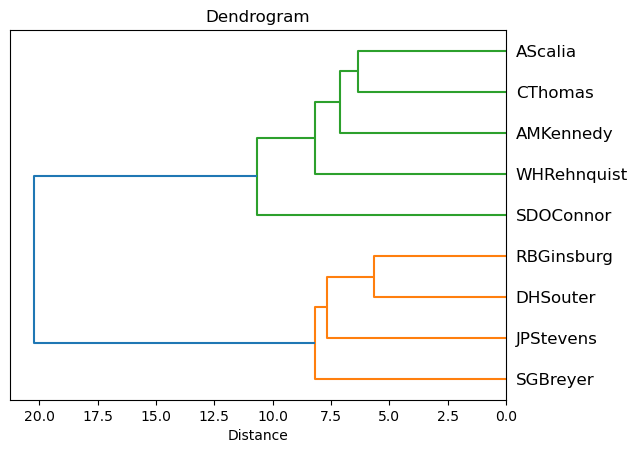

In [35]:
linkage_matrix = linkage(voteMat_df.loc[2001,'allVotes'].T, method='ward',optimal_ordering=True)
plt.figure()
dendrogram(linkage_matrix,labels=voteMat_df.loc[2001,'justiceName'],
            orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()